# Table of Contents
 <p><div class="lev1 toc-item"><a href="#reading-and-preparing-data" data-toc-modified-id="reading-and-preparing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>reading and preparing data</a></div>

# reading and preparing data

In [8]:
#library(ggbiplot)
library(plyr)
library(tidyverse, quiet=T)
library(traj)
library(caret, quiet=T)

In [45]:
dat0 <- read.csv("../training_ultrasound.csv")

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID),
        PARITY = ifelse(STUDYID==1, PARITY-1, PARITY)
        )
dat.raw %>% glimpse
# clean data, remove samples with only one observation and after-birth
dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1) %>%
    filter(AGEDAYS<0)


dat.train.raw = dat %>% ungroup %>%
    select(GAGEDAYS, SUBJID, ABCIRCM, HCIRCM, BPDCM, FEMURCM, PARITY, STUDYID, SEX, BWT_40) %>%
#    filter(!is.na(ABCIRCM)) %>% group_by(SUBJID) %>%
    filter(complete.cases(.)) %>%
    mutate(measurementId = row_number(), tot_measurements=n()) %>%
#    filter(measurementId < 7) %>%
#    filter(tot_measurements >1) %>% 
    ungroup
#     filter(GAGEDAYS > 150, GAGEDAYS <210)

dat.train = dat.train.raw

dat.train.raw %>% head

Observations: 17,370
Variables: 37
$ STUDYID       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SUBJID        <int> 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003,...
$ SEXN          <int> 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SEX           <fctr> Female, Female, Female, Male, Male, Male, Male, Male...
$ GAGEBRTH      <int> 276, 276, 276, 280, 280, 280, 280, 280, 280, 280, 280...
$ BIRTHWT       <int> 3540, 3540, 3540, 3100, 3100, 3100, 3100, 3100, 3100,...
$ BIRTHLEN      <dbl> 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3,...
$ BIRTHHC       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...
$ DELIVERY      <fctr> Category 2.0, Category 2.0, Category 2.0, Category 2...
$ PARITY        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ GRAVIDA       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GAGEDAYS      <int> 255, 277, 669, 223, 224, 263, 266, 281, 321, 463, 645...
$ AGEDAYS       <

GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,PARITY,STUDYID,SEX,BWT_40,measurementId,tot_measurements
255,1002,32.5,33.4,9.1,7.3,0,1,Female,3.614882,1,7827
223,1003,25.6,29.2,8.2,6.3,0,1,Male,3.100000,2,7827
224,1003,25.6,29.2,8.2,6.3,0,1,Male,3.100000,3,7827
263,1003,30.2,31.0,9.1,7.2,0,1,Male,3.100000,4,7827
266,1003,30.2,31.0,9.1,7.2,0,1,Male,3.100000,5,7827
169,1005,18.7,21.9,5.9,4.1,0,1,Male,2.988224,6,7827


# simple regression using GAGEDAYS as covariate

In [57]:
ctrl <- trainControl( method="boot", number=10, repeats=3)

dat.gbm = train(BWT_40~., 
                data=dat.train.raw %>%select(-measurementId, -tot_measurements, -SUBJID), 
                method="gbm", 
                preProcess=c("center", "scale", "knnImpute"), 
                verbose=F)


,var,rel.inf
ABCIRCM,ABCIRCM,46.5523855
GAGEDAYS,GAGEDAYS,31.2329573
FEMURCM,FEMURCM,6.8411134
BPDCM,BPDCM,5.6551662
SEXMale,SEXMale,5.4575569
HCIRCM,HCIRCM,3.2290470
PARITY,PARITY,0.8980230
STUDYID,STUDYID,0.1337506


A gradient boosted model with gaussian loss function.
150 iterations were performed.
There were 8 predictors of which 8 had non-zero influence.

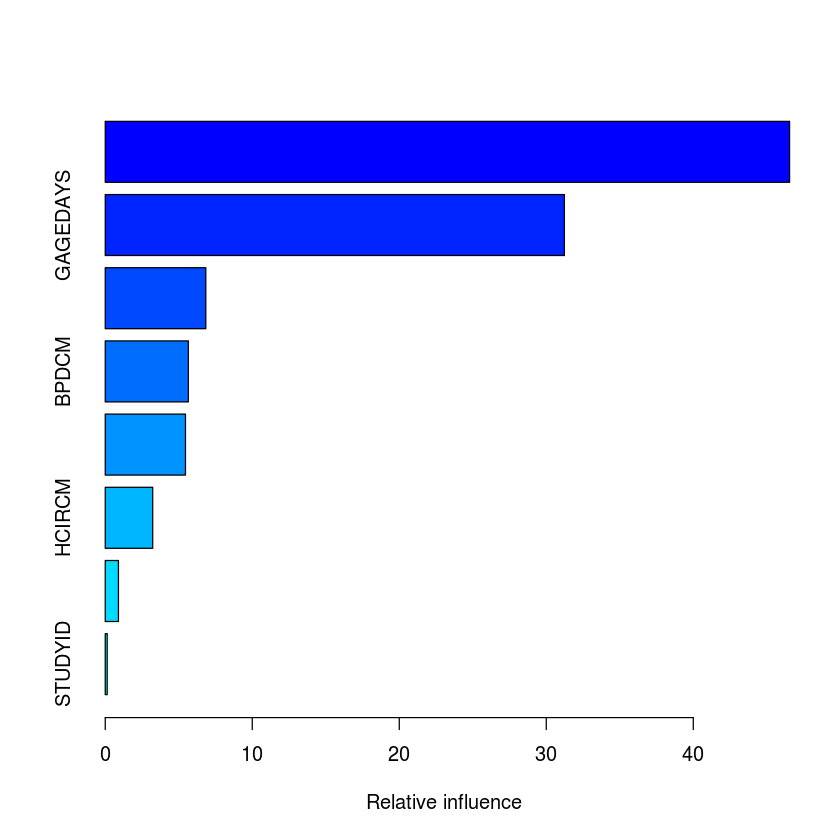

In [80]:
#dat.gbm %>% summary
dat.gbm$finalModel %>% summary

dat.gbm$finalModel 

In [82]:

mse <- mean(residuals(dat.gbm)^2)
rmse <- sqrt(mse)
rmse

[1] 0.2943591

In [83]:
R2(predict(dat.gbm, dat.training))
plot(dat.gbm)

ERROR: Error in predict.train(dat.gbm, dat.training): object 'dat.training' not found


# Random Forests

In [68]:
ctrl <- trainControl( method="boot", number=10, repeats=3)

dat.gbm = train(BWT_40~., 
                data=dat.train.raw %>%select(-measurementId, -tot_measurements, -SUBJID), 
                method="adaboost", 
                preProcess=c("center", "scale", "knnImpute"), 
                verbose=F)

Loading required package: fastAdaboost


ERROR: Error in train.default(x, y, weights = w, ...): wrong model type for regression


gbm variable importance

         Overall
ABCIRCM  100.000
GAGEDAYS  73.519
SEXMale   13.279
FEMURCM   13.051
BPDCM     11.179
HCIRCM     7.329
PARITY     2.643
STUDYID    0.000

Stochastic Gradient Boosting 

7827 samples
   8 predictors

Pre-processing: centered (8), scaled (8), nearest neighbor imputation (8) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 7827, 7827, 7827, 7827, 7827, 7827, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared 
  1                   50      0.3397188  0.1270177
  1                  100      0.3329582  0.1631067
  1                  150      0.3282487  0.1863651
  2                   50      0.3256746  0.2028317
  2                  100      0.3146452  0.2497748
  2                  150      0.3085135  0.2744417
  3                   50      0.3183449  0.2364240
  3                  100      0.3068683  0.2823535
  3                  150      0.3021581  0.2995447

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
RMSE was used to select the optimal model using  the smallest value.
T

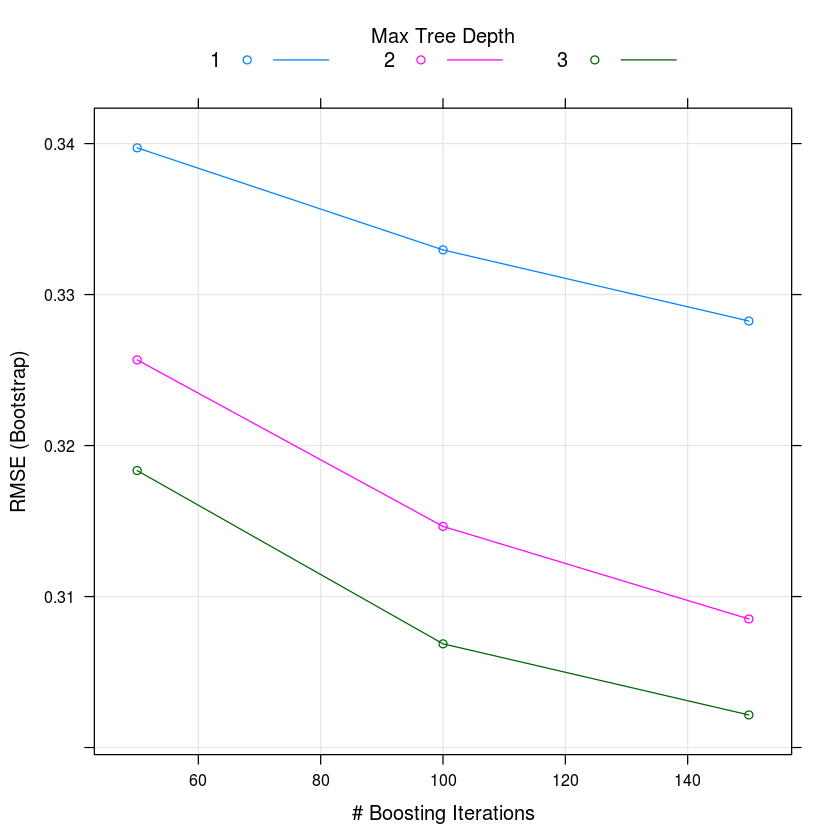

In [54]:
varImp(dat.gbm)
dat.gbm
plot(dat.gbm)

# Model for first weeks (15 to 25)


In [50]:
ctrl <- trainControl(method="repeatedcv", number=10, repeats=3)

dat.gbm = train(BWT_40~., 
                data=dat.train.raw %>% select(-measurementId, -tot_measurements, -SUBJID) %>%
                    filter(GAGEDAYS> 15*7, GAGEDAYS<25*7), 
                method="gbm", 
                preProcess=c("center", "scale", "knnImpute"), 
                verbose=F)

gbm variable importance

         Overall
GAGEDAYS  100.00
ABCIRCM    93.12
HCIRCM     68.62
FEMURCM    46.02
BPDCM      29.54
SEXMale    21.96
PARITY     11.61
STUDYID     0.00

Stochastic Gradient Boosting 

1625 samples
   8 predictors

Pre-processing: centered (8), scaled (8), nearest neighbor imputation (8) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1625, 1625, 1625, 1625, 1625, 1625, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared  
  1                   50      0.3567503  0.08471134
  1                  100      0.3534903  0.09898450
  1                  150      0.3517074  0.10760393
  2                   50      0.3519120  0.10696286
  2                  100      0.3495576  0.11925697
  2                  150      0.3498290  0.12178875
  3                   50      0.3498301  0.11670139
  3                  100      0.3494758  0.12322557
  3                  150      0.3508800  0.12313697

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
RMSE was used to select the optimal model using  the smalles

ERROR: Error in confusionMatrix.train(dat.gbm): confusion matrices are only valid for classification models


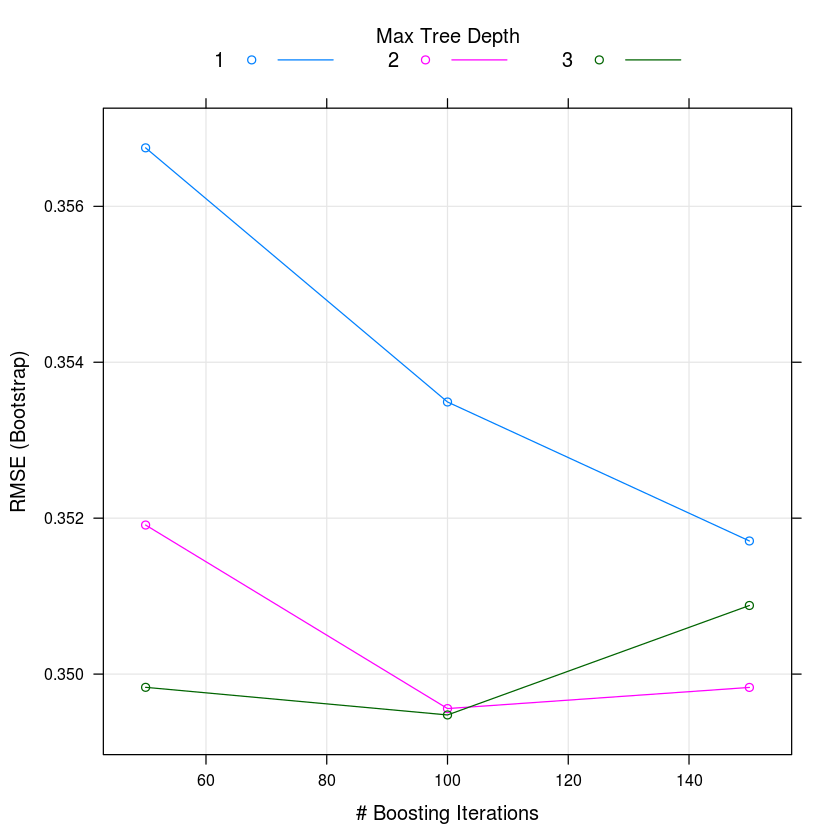

In [52]:
varImp(dat.gbm)
dat.gbm
plot(dat.gbm)

# regression with GAGEDAYS as weights


In [79]:

dat.gbm = train(BWT_40~., 
                data=dat.train.raw %>%select(-measurementId, -tot_measurements, -SUBJID), 
                method="gbm",
                weights=GAGEDAYS,
                preProcess=c("center", "scale", "knnImpute"), 
                verbose=F)